## Extraer preguntas de contenido de You Tube

In [73]:
import os
from llama_index.core.evaluation import DatasetGenerator, RelevancyEvaluator
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import VectorStoreIndex
from llama_index.llms.gradient import GradientBaseModelLLM
from llama_index.embeddings.gradient import GradientEmbedding
from llama_index.core import set_global_service_context
from llama_index.core import ServiceContext
import pandas as pd
import json
from tqdm import tqdm
from llama_index.extractors.entity import EntityExtractor
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.ingestion import IngestionPipeline
import pickle
import matplotlib.pyplot as plt
from collections import Counter


/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/re/_parser.py:461: RuntimeWarning: coroutine 'BaseExtractor.aprocess_nodes' was never awaited
  sourcematch = source.match


In [2]:
with open("/Users/jucampo/Desktop/Ideas/youtube_audios/credentials.json","r") as credentials:
    credentials_dict = json.load(credentials)
os.environ["OPENAI_API_KEY"] = credentials_dict['open_ai']
os.environ['GRADIENT_ACCESS_TOKEN'] = credentials_dict['gradient']
os.environ['GRADIENT_WORKSPACE_ID'] =  credentials_dict['gradient_id']

In [3]:
llm = GradientBaseModelLLM(
    base_model_slug="llama2-7b-chat",
    max_tokens=400,
)

In [4]:
embed_model = GradientEmbedding(
    gradient_access_token = os.environ["GRADIENT_ACCESS_TOKEN"],
    gradient_workspace_id = os.environ["GRADIENT_WORKSPACE_ID"],
    gradient_model_slug="bge-large",
)

In [5]:
service_context = ServiceContext.from_defaults(
    llm = llm,
    embed_model = embed_model,
    chunk_size=256,
)

set_global_service_context(service_context)

/var/folders/hs/vf4ldkdn15n5w_5y8gj10s0h37drkd/T/ipykernel_70817/3337229202.py:1: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


In [7]:
documents = SimpleDirectoryReader("/Users/jucampo/Desktop/Ideas/my_env/video_to_text/youTube_text").load_data()
print(f"Loaded {len(documents)} document(s).")

Loaded 48 document(s).


In [8]:
index = VectorStoreIndex.from_documents(documents,
                                        service_context=service_context)
query_engine = index.as_query_engine()

In [82]:
question1 = 'sabiendo que este documento trata sobre la reforma de salud en colombia,que preguntas se abordan en el "contenido '
question2 = 'Puedes decirme los nombres y cargos de las personas en el texto del "contenido 0" especificamente'

In [84]:
l_answers = []
for i in range(17):
    response = query_engine.query(question1+str(i))
    answer1 = str(response.response)
    l_answers.append(answer1)

In [139]:
idx=16
idx_ini = l_answers[idx].find("1. ")
idx_end = l_answers[idx].rfind("?")
for sub_answer in l_answers[idx][idx_ini:idx_end].split("\n"):
    print(sub_answer)

1. How does the current system of healthcare in Colombia work?
2. What are the challenges faced by the system, such as inefficiencies and lack of resources?
3. How does the proposed reform aim to address these challenges and improve the system?
4. What is the role of the government in implementing the reform?
5. How will the reform impact the cost of healthcare in Colombia?
6. What are the potential risks and challenges associated with the reform?
7. How can the reform be successfully implemented and sustained over time?

In light of the new context, the refined answer to the query "What questions are addressed in Contenido 16 of the document


In [118]:
df_questions = pd.DataFrame()
l_answer_clean = []
idx_ = []
for j in range(17):
    idx_ini = l_answers[j].find("1. ")
    idx_end = l_answers[j].rfind("?")
    for sub_answer in l_answers[j][idx_ini:idx_end].split("\n"):
        l_answer_clean.append(sub_answer[2:]) 
        idx_.append(j)
df_questions["idx_q"]=idx_
df_questions["question"]=l_answer_clean

In [119]:
df_questions["question"].nunique()

106

In [120]:
df_questions.dropna()

,idx_q,question
0,0,How will the reform address the disparities i...
1,0,. What specific measures will be implemented t...
2,0,. How will the government measure the success ...
3,0,
4,0,re is the updated list of questions that are l...
...,...,...
110,16,How will the reform impact the cost of health...
111,16,What are the potential risks and challenges a...
112,16,How can the reform be successfully implemente...
113,16,


In [121]:
df_questions.to_csv("question_from_videos.csv")

In [83]:
response = query_engine.query(question1+str(2))
answer1 = str(response.response)
for sub_answer in answer1.split("\n"):
    print(sub_answer)

 Based on the additional context provided, it appears that the 'content 2' section of the document is discussing the potential challenges and obstacles to implementing the government's proposal for health reform in Colombia. The section may be addressing questions such as:

1. How will the government overcome the political and economic challenges to implementing the reform?
2. What are the potential risks and unintended consequences of the reform, and how can they be mitigated?
3. How will the government ensure that the reform is sustainable and long-lasting, despite potential short-term challenges?
4. What are the potential impacts of the reform on marginalized communities, and how can they be addressed?
5. How will the government measure the success of the reform, and what metrics will be used to evaluate its effectiveness?

These questions are likely being addressed in the 'content 2' section of the document through a combination of textual analysis, data visualization, and expert o

In [41]:
response = query_engine.query(question2)
answer = str(response.response)
for sub_answer in answer.split("\n"):
    print(sub_answer)

 Based on the additional context provided, it is still not possible to identify any specific names or positions of individuals mentioned in the "contenido 0" section of the text. The section continues to discuss the potential consequences of the transition of patients from one EPS to another, without providing any information that could help identify specific individuals.

Therefore, the original answer remains unchanged: Based on the context information provided, there are no specific names or positions of individuals mentioned in the "contenido 0" section of the text.


In [51]:
with open('/Users/jucampo/Desktop/Ideas/my_env/metadata.pkl', 'rb') as archivo:
    # Cargar el objeto desde el archivo
    entuty_recog = pickle.load(archivo)

In [59]:
len(entuty_recog)

93

In [72]:
l_entities = []
for i in tqdm(range(len(entuty_recog))):
    dict_data = entuty_recog[i].metadata
    if "entities" in dict_data.keys():
        l_entities = l_entities+dict_data["entities"]

100%|██████████| 93/93 [00:00<00:00, 414968.37it/s]


In [78]:
def graficar_frecuencia_palabras(lista_palabras, k=1):
    # Contar la frecuencia de las palabras
    contador_palabras = Counter(lista_palabras)

    # Filtrar palabras que se repiten más de k veces
    contador_filtrado = {palabra: frecuencia for palabra, frecuencia in contador_palabras.items() if frecuencia > k}
    contador_total = {palabra: frecuencia for palabra, frecuencia in contador_palabras.items()}

    # Obtener palabras y frecuencias para graficar
    palabras = list(contador_filtrado.keys())
    frecuencias = list(contador_filtrado.values())

    # Crear la gráfica de barras
    plt.figure(figsize=(10, 6))
    plt.bar(palabras, frecuencias, color='skyblue')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de Palabras')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()
    return contador_total

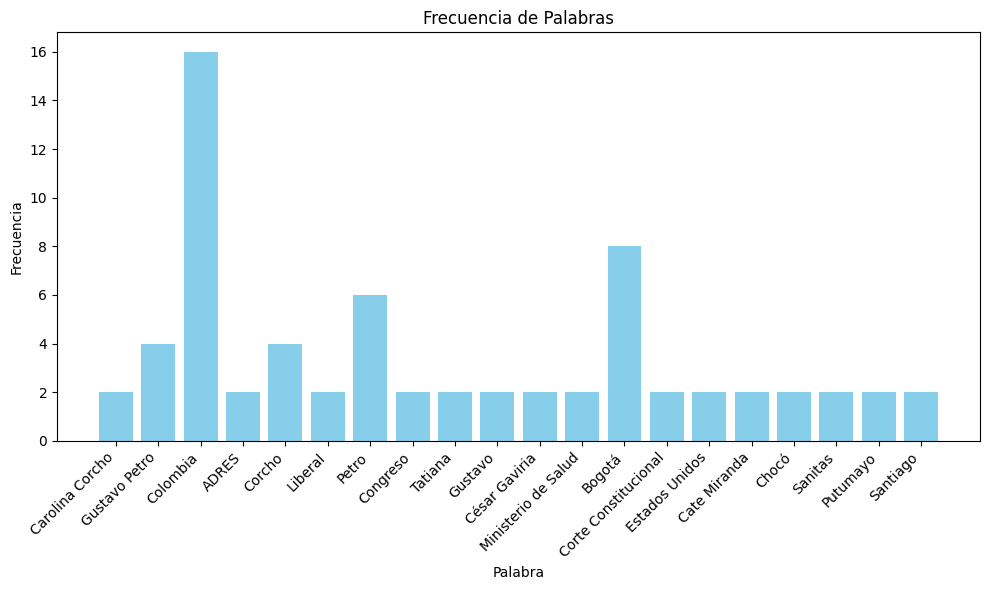

In [79]:
count_words = graficar_frecuencia_palabras(l_entities)

In [80]:
count_words

{'Carolina Corcho': 2,
 'Gustavo Petro': 4,
 'Colombia': 16,
 'WhatsApp': 1,
 'Juliana': 1,
 'Juan': 1,
 'Pedro': 1,
 'ADRES': 2,
 'Corcho': 4,
 'Liberal': 2,
 'U': 1,
 'Petro': 6,
 'Congreso': 2,
 'Conservador': 1,
 'Alejandro Gaviria': 1,
 'Tatiana': 2,
 'La Silla Vacía': 1,
 'Gustavo Morales': 1,
 'Gustavo': 2,
 'nosotras': 1,
 'Jaime Ramírez': 1,
 'César Gaviria': 2,
 'Ministerio de Salud': 2,
 'pandemia': 1,
 'Aderes': 1,
 'Seguro Social': 1,
 'Bogotá': 8,
 'Hospital San Pedro Claver': 1,
 'Cuarto': 1,
 'Salucop': 1,
 'Protección Especial para los Enfermos de VIH-Sida': 1,
 'Corte Constitucional': 2,
 'Sabaneta': 1,
 'Nicolás Petro': 1,
 'enfermedades complejas': 1,
 'Cruz Verde': 1,
 'Audifarma': 1,
 'Blockchain': 1,
 'Zuckerberg': 1,
 'Estados Unidos': 2,
 'Pfff': 1,
 'Hashtag': 1,
 'Pacto Histórico': 1,
 'Partido Conservador': 1,
 'Queso': 1,
 'Combo Puya Sencilla Royal': 1,
 'Telegram': 1,
 'Álvaro Uribe Vélez': 1,
 'Antioquia': 1,
 'Levi': 1,
 'Teatro ABC': 1,
 'Karen Abudin'